# Extract Comments

In [ ]:
from api_helper import fetch_comments , extract_youtube_video_id 
import os
api_key = os.getenv("YOUTUBE_API_KEY")
video_id = extract_youtube_video_id("https://www.youtube.com/watch?v=cIla9axQRyM&t=69s"  )
comments = fetch_comments(video_id,api_key=api_key, max_comments=500)
comments


[{'text': 'Thank you for watching. Please click the subscribe tab and then the "bell" icon to subscribe to our channel here on YouTube and get notified when new content is posted... And thank you for your interest in science!   -- Andrew',
  'timestamp': '2025-09-11T12:59:22Z',
  'authorId': 'UC2D2CMWXMOVWx7giW1n3LIg'},
 {'text': "Thanks Andrew Huberman,I love it this video because it's useful to me and also it was constantly to keep it's brain to be stronger for everything and moreover smarter and genius.thanks Andrew Huberman👍🏻💪🏻😉😊🙂🙃😘❤😍",
  'timestamp': '2026-01-29T10:19:00Z',
  'authorId': 'UCnUAqGVIHzwiHS1P7v1tmzQ'},
 {'text': 'You are telling Fat is important now but in our Science Ayurveda.. Fat and its importance is already told 2000 years ago and we are practicing it on our patients in our traditional practice.. but many propagandists called our science Ayurveda a joke, a placebo science.. RIP to all of those now..',
  'timestamp': '2026-01-25T06:55:57Z',
  'authorId': 'UCooFw9

In [20]:
list_of_comments = [x["text"] for x in comments]
list_of_comments

['Thank you for watching. Please click the subscribe tab and then the "bell" icon to subscribe to our channel here on YouTube and get notified when new content is posted... And thank you for your interest in science!   -- Andrew',
 'This guy has turned- full on Generic. \nI pre-ordered  his book that was due out in a few mos, TWO YRS AGO!!  Nope, still not out. \nYou can’t leave comment on anything he vpn posts on social media, I wonder why. \nI liked him, now I want my money back and they are just using his voice in these video, nothing he says means anything anymore',
 'Maqui berries are the berries highest in anthocyanadins',
 'What about lions mane mushrooms for cognitive improvement? Also UCSF’s BrainHQ from Posit Science',
 "Hi Dr Huberman......new to the channel but seems genuinly produced after watching a few videos I think your standpoint on the issue is unbiased from an experiienced based caring person.\n\nYour field of study is an absolute revolutionaly important thing to ha

In [14]:
from typing  import List , Dict , TypedDict

class CommentsState(TypedDict):
    comments: List[str]
    topics: List[str]
    classified_comments: List[Dict[str, str]]

In [22]:
from dotenv  import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv()

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

In [24]:
# functions to process comments will go here
def topics_generator(state : CommentsState) -> CommentsState:
    # implement topic generation logic
    comments = state["comments"]
    prompt = f"""
    You are analyzing YouTube comments.

    TASK:
    - Identify 5–8 distinct discussion topics
    - Topics must be short noun phrases
    - Avoid overlap
    - Do NOT include sentiment

    COMMENTS:
    {comments}

    Return JSON only:
    {{
      "topics": ["topic1", "topic2", "..."]
    }}
    """
    response = llm.invoke(prompt)
    state["topics"] = response["topics"]
    return state

def classify_comments(state: CommentsState) -> CommentsState:
    topics = state["topics"]
    comments = state["comments"]

    prompt = f"""
    You are classifying YouTube comments into topics.

    TOPICS:
    {topics}

    RULES:
    - Each comment gets ONE topic
    - Use "Other" only if necessary

    COMMENTS:
    {comments}

    Return JSON only:
    [
      {{
        "comment": "...",
        "topic": "topic_name"
      }}
    ]
    """

    response = llm.invoke(prompt)
    state["classified_comments"] = response["topics"]
    return state

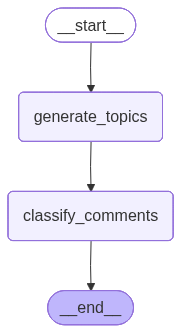

In [26]:
from langgraph.graph import StateGraph , START  , END

graph = StateGraph(CommentsState)
graph.add_node("generate_topics", topics_generator)
graph.add_node("classify_comments", classify_comments)

graph.add_edge(START , "generate_topics")
graph.add_edge("generate_topics", "classify_comments")
graph.add_edge("classify_comments", END)

workflow = graph.compile()
workflow

In [27]:
initial_state: CommentsState = {
    "comments": list_of_comments}

final_state = workflow.invoke(initial_state)   
final_state

TypeError: 'AIMessage' object is not subscriptable

# check

In [1]:
from pydantic import BaseModel, Field
from typing import TypedDict, List

class TopicState(TypedDict):
    comments: List[str]
    topics: List[str]
    classified_comments: List[dict]
    
class TopicDiscoveryOutput(BaseModel):
    topics: List[str] = Field(
        description="Short, non-overlapping topic names"
    )
    
class ClassifiedComment(BaseModel):
    comment: str
    topic: str


class TopicClassificationOutput(BaseModel):
    results: List[ClassifiedComment]


In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv  import load_dotenv
load_dotenv()
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.0
)

topic_discovery_llm = llm.with_structured_output(TopicDiscoveryOutput)
topic_classification_llm = llm.with_structured_output(TopicClassificationOutput)


In [16]:
def discover_topics(state: TopicState):
    comments_text = "\n".join(state["comments"][:100])

    prompt = f"""
You are analyzing YouTube comments.

TASK:
- Create discussion topics from the comments
- Topics must be created by you
- 2–3 words per topic
- No sentiment words
- Max 8 topics
- Dont Include  "Other" as a topic
COMMENTS:
{comments_text}
"""

    response = topic_discovery_llm.invoke(prompt)

    return {
        **state,
        "topics": response.topics
    }


In [26]:
def classify_comments(state: TopicState):
    comments_text = "\n".join(state["comments"])
    topics_text = ", ".join(state["topics"])

    prompt = f"""
You are classifying comments into topics.

TOPICS:
{topics_text}

RULES:
- Use ONLY the provided topics
- One topic per comment
- Do not invent new topics
- No explanations

COMMENTS:
{comments_text}
"""

    response = topic_classification_llm.invoke(prompt)

    return {
        **state,
        "classified_comments": [
            item.model_dump() for item in response.results
        ]
    }


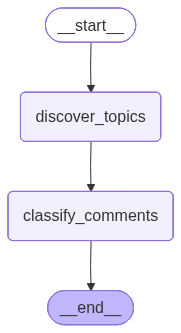

In [27]:
from langgraph.graph import StateGraph , START , END

graph = StateGraph(TopicState)

graph.add_node("discover_topics", discover_topics)
graph.add_node("classify_comments", classify_comments)

graph.add_edge(START , "discover_topics")
graph.add_edge("discover_topics", "classify_comments")
graph.add_edge("classify_comments" , END)
topic_graph = graph.compile()
topic_graph

In [28]:
#list
result = topic_graph.invoke({
    "comments": list_of_comments[10:20]
})

print("Discovered Topics:", result["topics"])
#print("Classified Comments:", result["classified_comments"])


Discovered Topics: ['Brain food pairing', 'Choline atropine effects', 'Taurine sclera bleeding', 'Alpha GPC alternatives', 'Hydration vitamin supplements', 'Subtitle language requests']


In [30]:
result['classified_comments']

[{'comment': '28:38 I’m confused here. So if we want to consume more of something because it’s good for our brain, we pair it with something we like? Or something that changes the brain’s metabolism? Or that is the thing the brain is seeking which is the first group of foods which we are trying to learn to like? “That other food” is what threw me off here. What falls in the category of “that other food”?',
  'topic': 'Brain food pairing'},
 {'comment': 'If Choline helps focus and atropine blocks it and creates hallucinations, is  choline the setting on a timing light and atropine changes the setting or the speed of the strobe light to see things that are going to slow or fast for choline to focus on?',
  'topic': 'Choline atropine effects'},
 {'comment': "I don't believe for one second that taurine caused bursting of microvasculature in your slcera. Just because your taking taurine was chronoogically associated with your sclera bleeding doesn't mean that it was the cause of it. You are

In [31]:
result

{'comments': ['28:38 I’m confused here. So if we want to consume more of something because it’s good for our brain, we pair it with something we like? Or something that changes the brain’s metabolism? Or that is the thing the brain is seeking which is the first group of foods which we are trying to learn to like? “That other food” is what threw me off here. What falls in the category of “that other food”?',
  'If Choline helps focus and atropine blocks it and creates hallucinations, is  choline the setting on a timing light and atropine changes the setting or the speed of the strobe light to see things that are going to slow or fast for choline to focus on?',
  "I don't believe for one second that taurine caused bursting of microvasculature in your slcera. Just because your taking taurine was chronoogically associated with your sclera bleeding doesn't mean that it was the cause of it. You are showing some very bad judgment with that.",
  'What is the best alternative for alpha gpc? I k

# OLLAMS + LangChain

### LangChain

In [2]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM

template = """Question: {question}

Answer: Let's think step by step."""

prompt = ChatPromptTemplate.from_template(template)

model = OllamaLLM(model="llama3.2:latest")

chain = prompt | model

chain.invoke({"question": "What is LangChain?"})

"LangChain is an open-source Python library that provides a simple and flexible way to build blockchain data pipelines.\n\nHere are the steps to understand what LangChain is:\n\n1. **Blockchain Data Pipelines**: Blockchain data pipelines refer to the process of collecting, processing, and storing data from various sources in a decentralized manner. LangChain aims to simplify this process by providing a standardized framework for building these pipelines.\n\n2. **Decentralized Applications (dApps)**: LangChain was specifically designed to support decentralized applications (dApps), which are built on top of blockchain technology. dApps require efficient data management and processing, making LangChain an ideal solution.\n\n3. **Modular Architecture**: LangChain has a modular architecture that allows developers to easily integrate it with existing blockchain projects or build new ones from scratch. This modularity enables users to customize their pipelines according to their specific nee

### LangGraph

In [10]:
from langchain_ollama.llms import OllamaLLM
from langgraph.graph import StateGraph

llm = OllamaLLM(model="llama3.2:latest")

def agent_node(state):
    response = llm.invoke(state["input"])
    return {"output": response}

graph = StateGraph(dict)
graph.add_node("agent", agent_node)
graph.set_entry_point("agent")
graph.set_finish_point("agent")

app = graph.compile()

response = app.invoke({"input": "what is Deep Learning?"})


In [11]:
response['output']

'Deep learning is a subset of machine learning that involves the use of artificial neural networks (ANNs) to analyze and interpret data. The term "deep" refers to the fact that these ANNs have multiple layers, rather than just one or two.\n\nArtificial neural networks are inspired by the structure and function of the human brain, where neurons process and transmit information through complex networks of interconnected nodes. In deep learning, this concept is extended to create models with hundreds or thousands of layers, each consisting of multiple processing units called artificial neurons.\n\nThe key characteristics of deep learning include:\n\n1. **Large datasets**: Deep learning requires large amounts of data to train the models.\n2. **Hierarchical representation**: Each layer in a deep neural network represents an increasingly abstract level of abstraction, allowing the model to capture complex patterns and relationships in the data.\n3. **Non-linear processing**: Artificial neuro

# testing input output

In [ ]:
import os
import requests

def fetch_comments(video_id,api_key):
  url = "http://127.0.0.1:8000/fetch_comments"

  payload = {
    "video_id": video_id,
    "api_key": api_key,
    "max_comments": 500
  }

  headers = {
      "Content-Type": "application/json"
  }

  response = requests.post(url, json=payload, headers=headers)

 # print("Status code:", response.status_code)
  #print("Response JSON:")
  comments = response.json()
  #print(comments)
  return response.json()
api_key = os.getenv("YOUTUBE_API_KEY")
fetch_comments(video_id="TfkP5ubz1z4" , api_key=api_key)

[{'text': '¿Hay Latinos aquí?\nP.S. Check out our latest official release as a record label 7clouds: https://youtu.be/cOnT6k8itRE',
  'timestamp': '2019-06-12T18:31:47Z',
  'authorId': 'UCNqFDjYTexJDET3rPDrmJKg'},
 {'text': 'I love this song',
  'timestamp': '2026-02-01T07:06:33Z',
  'authorId': 'UCsfyc7xdpzs9WDaZuMtYg-A'},
 {'text': '1st February 2026',
  'timestamp': '2026-02-01T02:35:03Z',
  'authorId': 'UCG-deVShIq5Vlz6xAnu-c6Q'},
 {'text': '비버 목소리는 쵝오👍👍👍👍👍',
  'timestamp': '2026-01-31T18:59:54Z',
  'authorId': 'UCqtvJz5bKooVFA661V4T_ow'},
 {'text': 'Yes',
  'timestamp': '2026-01-31T17:48:06Z',
  'authorId': 'UCIdR83UesAA9vzJTBpj2aqw'},
 {'text': 'de sbacito',
  'timestamp': '2026-01-31T15:37:10Z',
  'authorId': 'UCl_p39m9h0kiIIPUb9AX0Kw'},
 {'text': 'Eagdrtdttttttttt',
  'timestamp': '2026-01-31T14:19:53Z',
  'authorId': 'UCxeEjt7ito-723tADAZzn1A'},
 {'text': 'Anyone 2026 februari',
  'timestamp': '2026-01-31T12:32:14Z',
  'authorId': 'UCjsdTCtjGfV5_yAAFAQk_nA'},
 {'text': '❤❤❤❤❤❤

In [ ]:
import os
from api_helper import predict_comments,fetch_comments_api , predict_with_timestamps_api
api_key = os.getenv("YOUTUBE_API_KEY")
comments = fetch_comments_api(video_id="lIo9FcrljDk",api_key=api_key , max_comments=100)
pred_timestamps = predict_with_timestamps_api(comments=comments)
ls_predictions  = predict_comments(comments=comments)
ls_predictions

[{'comment': {'text': 'This is the second episode of Huberman Lab Essentials—short episodes (~30 minutes) that pull the essential science and protocol takeaways from past Huberman Lab episodes. Essentials will be released every Thursday. And rest assured, our full-length episodes will still be released every Monday.\n\nThank you for watching. If you enjoyed this topic and episode, please click the "like" button below the episode title, and subscribe to our channel here on YouTube. Thank you for your interest in science!   -- Andrew',
   'timestamp': '2024-11-21T13:46:48Z',
   'authorId': 'UC2D2CMWXMOVWx7giW1n3LIg'},
  'sentiment': '0'},
 {'comment': {'text': "I keep going to sleep around midnight, attempting to wake up between 7:00-7:30 (for sunrise walks to anchor my circadian rhythm) but i keep waking up at around 6:00 and am unable to go back to sleep for that last 1hr+. this has been going on for over a week now. i've seen your other sleep related vids, about how using your wake up

In [2]:
pred_timestamps

[{'comment': 'This is the second episode of Huberman Lab Essentials—short episodes (~30 minutes) that pull the essential science and protocol takeaways from past Huberman Lab episodes. Essentials will be released every Thursday. And rest assured, our full-length episodes will still be released every Monday.\n\nThank you for watching. If you enjoyed this topic and episode, please click the "like" button below the episode title, and subscribe to our channel here on YouTube. Thank you for your interest in science!   -- Andrew',
  'sentiment': '0',
  'timestamp': '2024-11-21T13:46:48+00:00'},
 {'comment': "I keep going to sleep around midnight, attempting to wake up between 7:00-7:30 (for sunrise walks to anchor my circadian rhythm) but i keep waking up at around 6:00 and am unable to go back to sleep for that last 1hr+. this has been going on for over a week now. i've seen your other sleep related vids, about how using your wake up time to help set your go to sleep time (cortisol-melatoni

In [15]:

positive , negative , neutral = 0, 0, 0
for item in predictions:
    #print(type(item["sentiment"]))
    if item=="1":
        positive+=1
    elif item =="-1":
        negative+=1
    else:
        neutral+=1
counts = {
    "1": positive,
    "0": neutral,
    "-1": negative
  }
counts

{'1': 52, '0': 409, '-1': 39}

In [ ]:
counts = {
    "1": 10,
    "0": 10,
    "-1": 20
  }

In [ ]:
[{'comment': {'text': 'I also',
   'timestamp': '2026-02-01T08:30:09Z',
   'authorId': 'UCeaL1OhUWUbAvXW_HhXydKg'},
  'sentiment': '0'},
 {'comment': {'text': 'Me',
   'timestamp': '2026-02-01T08:29:51Z',
   'authorId': 'UCeaL1OhUWUbAvXW_HhXydKg'},
  'sentiment': '0'},]

[{'comment': {'text': '¿Hay Latinos aquí?\nP.S. Check out our latest official release as a record label 7clouds: https://youtu.be/cOnT6k8itRE',
   'timestamp': '2019-06-12T18:31:47Z',
   'authorId': 'UCNqFDjYTexJDET3rPDrmJKg'},
  'sentiment': '0'},
 {'comment': {'text': 'I also',
   'timestamp': '2026-02-01T08:30:09Z',
   'authorId': 'UCeaL1OhUWUbAvXW_HhXydKg'},
  'sentiment': '0'},
 {'comment': {'text': 'Me',
   'timestamp': '2026-02-01T08:29:51Z',
   'authorId': 'UCeaL1OhUWUbAvXW_HhXydKg'},
  'sentiment': '0'},
 {'comment': {'text': 'I love this song',
   'timestamp': '2026-02-01T07:06:33Z',
   'authorId': 'UCsfyc7xdpzs9WDaZuMtYg-A'},
  'sentiment': '0'},
 {'comment': {'text': '1st February 2026',
   'timestamp': '2026-02-01T02:35:03Z',
   'authorId': 'UCG-deVShIq5Vlz6xAnu-c6Q'},
  'sentiment': '0'},
 {'comment': {'text': '비버 목소리는 쵝오👍👍👍👍👍',
   'timestamp': '2026-01-31T18:59:54Z',
   'authorId': 'UCqtvJz5bKooVFA661V4T_ow'},
  'sentiment': '0'},
 {'comment': {'text': 'Yes',
   'timesta

In [ ]:
from api_helper import count_sentiments_from_predictions
counts = count_sentiments_from_predictions(predictions=predictions)
print(counts)
generate_chart_api(counts)

{'1': 12, '0': 481, '-1': 7}


b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X\x00\x00\x02X\x08\x06\x00\x00\x00\xbef\x98\xdc\x00\x00\x00:tEXtSoftware\x00Matplotlib version3.10.8, https://matplotlib.org/\xc1[u\xce\x00\x00\x00\tpHYs\x00\x00\x0fa\x00\x00\x0fa\x01\xa8?\xa7i\x00\x00M@IDATx\x9c\xed\xdd\x07\x9c\\e\xbd\xff\xf1\xef\xd9\xbe\x9b-\xe9\xbdw\x12H\x0e\xe1p\xd2\t(\xa04\x11iJ\xf5b\xae\xa8\xd7\xc2\xb5\xa3r\xafx\xc5\x02x\xf5\xca\xf5\xda\xbd\xfeE\xf0\x02*\x82(XP\x92P\x87\x01\x86\x92F\x02\t)\x9b\xb6i\xbb\xd9^\xe6\xffz6\xcf\xe2&\xa4l9\xb3\xe7\xcc\xcc\xe7\xfdz\xcd+[fg~y6\xd9\xfd\xce\xefy\xce\xf38\xc9dR\x00\x00\x00\x08NN\x80\x8f\x05\x00\x00\x00\x02\x16\x00\x00@\xf0\xe8`\x01\x00\x00\x04\x8c\x80\x05\x00\x00\x100\x02\x16\x00\x00@\xc0\x08X\x00\x00\x00\x01#`\x01\x00\x00\x04\x8c\x80\x05\x00\x00\x100\x02\x16\x00\x00@\xc0\x08X\x00\x00\x00\x01#`\x01\x00\x00\x04\x8c\x80\x05\x00\x00\x100\x02\x16\x00\x00@\xc0\x08X\x00\x00\x00\x01#`\x01\x00\x00\x04\x8c\x80\x05\x00\x00\x100\x02\x16\x00\x00@\xc0\x08X\x00\x00\x00\x01#`\x01\x00\x00\x04\

**testing fastapi endpoint**

In [53]:
import requests

url = "http://127.0.0.1:8000/predict_with_timestamps"

payload = {
    "comments": comments
}

headers = {
    "Content-Type": "application/json"
}

response = requests.post(url, json=payload, headers=headers)

print("Status code:", response.status_code)
print("Response JSON:")
predict_with_timestamps = response.json()
predict_with_timestamps


Status code: 200
Response JSON:


[{'comment': '¿Hay Latinos aquí?\nP.S. Check out our latest official release as a record label 7clouds: https://youtu.be/cOnT6k8itRE',
  'sentiment': '0',
  'timestamp': '2019-06-12T18:31:47+00:00'},
 {'comment': '❤❤❤❤❤❤🎉🎉🎉🎉',
  'sentiment': '0',
  'timestamp': '2026-01-31T03:24:50+00:00'},
 {'comment': 'Flirty song😆🙃🤫',
  'sentiment': '0',
  'timestamp': '2026-01-31T01:16:25+00:00'},
 {'comment': 'Like this comment if you have arrived here in 2026!',
  'sentiment': '0',
  'timestamp': '2026-01-30T22:39:16+00:00'},
 {'comment': '1:47',
  'sentiment': '0',
  'timestamp': '2026-01-29T23:14:10+00:00'},
 {'comment': 'When someone sings with knowing the lyrics and u know the lyrics and u start smiling 😂',
  'sentiment': '0',
  'timestamp': '2026-01-29T19:23:19+00:00'},
 {'comment': '1:45 to 1:56😊😊😊❤❤❤',
  'sentiment': '0',
  'timestamp': '2026-01-29T11:34:16+00:00'},
 {'comment': '2026 anyone',
  'sentiment': '0',
  'timestamp': '2026-01-29T11:25:28+00:00'},
 {'comment': '1:36 best part ❤',

In [ ]:
positive = 0
negative = 0
neutral = 0
for item in response.json():
    if item["sentiment"] =="1":
        positive+=1
    elif item["sentiment"] =="-1":
        negative+=1
    else:
        neutral+=1
        
positive, negative , neutral 

(12, 7, 481)

Status code: 200


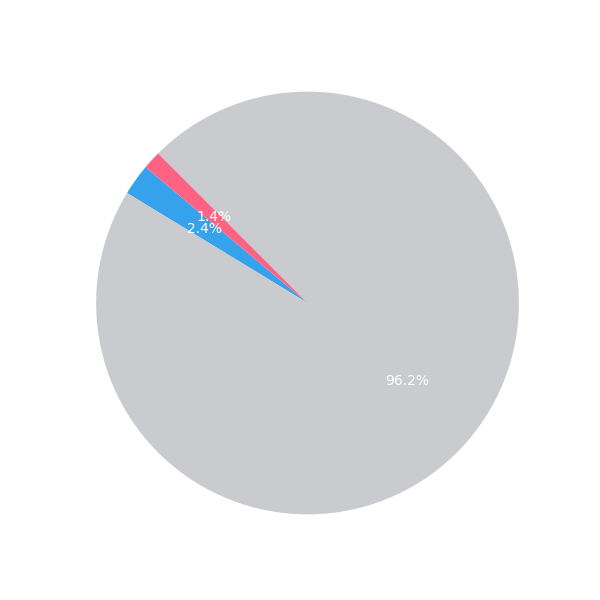

<class 'bytes'>


In [24]:
import requests
from IPython.display import Image, display
url = "http://127.0.0.1:8000/generate_chart"

payload = {
  "sentiment_counts": {
    "1": positive,
    "0": neutral,
    "-1": negative
  }
}
headers = {
    "Content-Type": "application/json"
}

response = requests.post(url, json=payload, headers=headers)

print("Status code:", response.status_code)
if response.status_code == 200:
    display(Image(data=response.content))
    print(type(response.content))
else:
    print(response.text)



Status code: 200


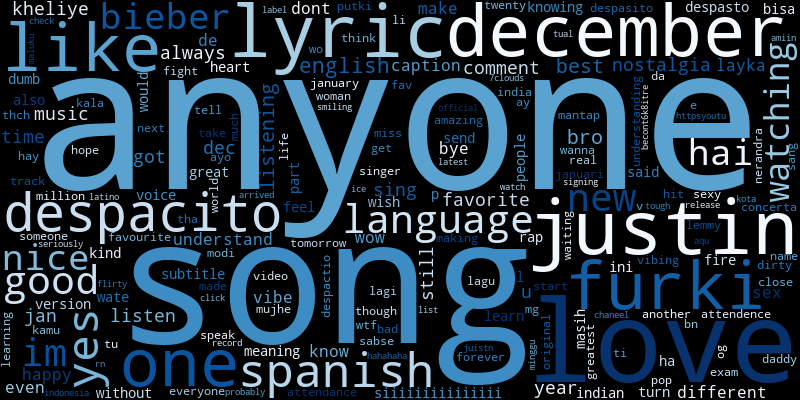

In [56]:
import requests
from IPython.display import Image, display
url = "http://127.0.0.1:8000/generate_wordcloud"

payload = {
  "comments" : comments
}
headers = {
    "Content-Type": "application/json"
}

response = requests.post(url, json=payload, headers=headers)

print("Status code:", response.status_code)
if response.status_code == 200:
    display(Image(data=response.content))
else:
    print(response.text)



Status code: 200


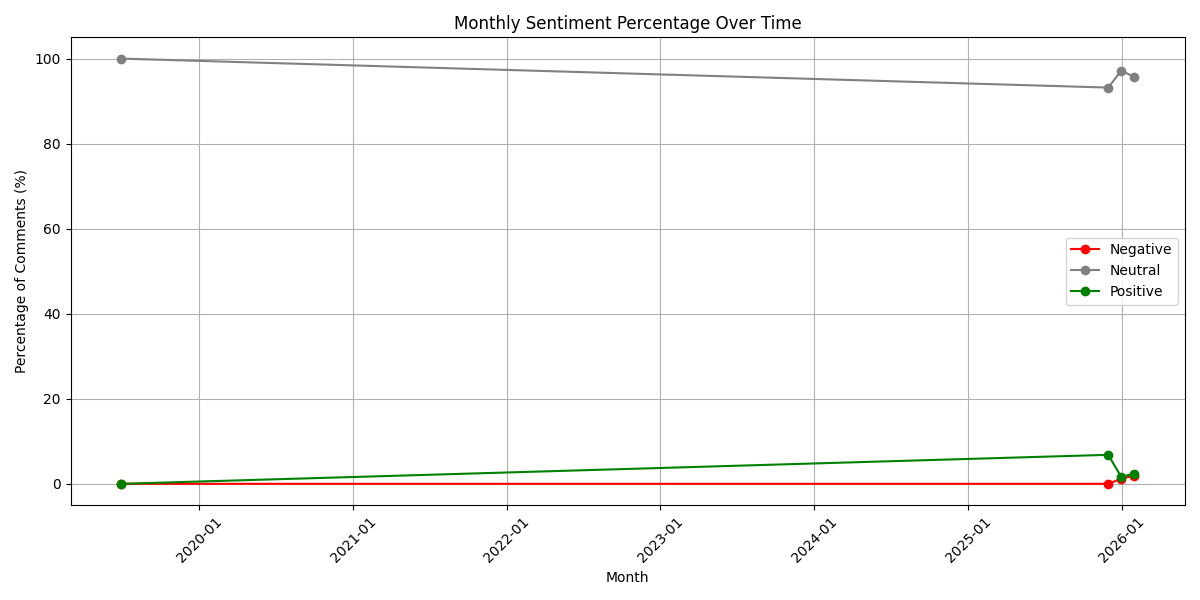

In [57]:
import requests
from IPython.display import Image, display
url = "http://127.0.0.1:8000/generate_trend_graph"

payload = {
  "sentiment_data" : predict_with_timestamps
}
headers = {
    "Content-Type": "application/json"
}

response = requests.post(url, json=payload, headers=headers)

print("Status code:", response.status_code)
if response.status_code == 200:
    display(Image(data=response.content))
else:
    print(response.text)



In [ ]:
import requests
def fetch_comments_api(video_id,api_key , max_comments):
  url = "http://127.0.0.1:8000/fetch_comments"

  payload = {
    "video_id": video_id,
    "api_key": api_key,
    "max_comments": 500
  }

  headers = {
      "Content-Type": "application/json"
  }

  response = requests.post(url, json=payload, headers=headers)

 # print("Status code:", response.status_code)
  #print("Response JSON:")
  comments = response.json()
  #print(comments)
  return response.json()

import os
video_id = "lIo9FcrljDk"
api_key = os.getenv("YOUTUBE_API_KEY") 
comments = fetch_comments_api(
        video_id=video_id,
        api_key=api_key,
        max_comments=500
    )

print("Comments Done")
print(comments)

NameError: name 'requests' is not defined